### Chain Using LangGraph
In this section we will see how we can build a simple chain using Langgraph that uses 4 important concepts

- How to use chat messages as our graph state
- How to use chat models in graph nodes
- How to bind tools to our LLM in chat models
- How to execute the tools call in our graph nodes 

In [1]:
# Load environment variables
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


#### How to use chat messages as our graph state
##### Messages

We can use messages which can be used to capture different roles within a conversation.
LangChain has various message types including HumanMessage, AIMessage, SystemMessage and ToolMessage.
These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Every message have these important components.

- content - content of the message
- name - Specify the name of author
- response_metadata - optionally, a dict of metadata (e.g., often populated by model provider for AIMessages)



In [2]:
# Note that messages can also have metadata attached to them
from langchain_core.messages import AIMessage,HumanMessage
from pprint import pprint

messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
messages.append(HumanMessage(content=f"I want to learn coding",name="Krish"))
messages.append(AIMessage(content=f"Which programming language you want to learn",name="LLMModel"))
messages.append(HumanMessage(content=f"I want to learn python programming language",name="Krish"))

for message in messages:
    message.pretty_print()



================================== Ai Message ==================================
Name: LLMModel

Please tell me how can I help
================================ Human Message =================================
Name: Krish

I want to learn coding
================================== Ai Message ==================================
Name: LLMModel

Which programming language you want to learn
================================ Human Message =================================
Name: Krish

I want to learn python programming language


### Chat Models

We can use the sequence of message as input with the chatmodels using LLM's and OPENAI.

In [3]:
# Get the result from an LLM
# You send the conversation to the LLM
from langchain_groq import ChatGroq
llm=ChatGroq(model="qwen/qwen3-32b")
result=llm.invoke(messages)
result

AIMessage(content='<think>\nOkay, the user wants to learn Python. Let me start by outlining a structured approach. First, they\'ll need the basics—installation, setup, and a simple "Hello, World!" to get them going. Maybe mention online platforms like Replit if they don\'t want to install anything.\n\nNext, the core concepts. Variables, data types, control structures. Should I list them in order? Yeah, starting with syntax, then moving to variables, data types, input/output. Then conditionals and loops. Functions and data structures like lists, tuples, dictionaries, sets. Oh, and error handling with try-except.\n\nAfter that, moving into more advanced topics. Object-oriented programming is essential. Modules and packages, file handling. Then introduce libraries like NumPy, Pandas, and maybe some frameworks like Django for web dev or Flask. Also, mention libraries for data science and automation.\n\nProjects are important for practice. Maybe suggest small projects like a calculator, to-

In [4]:
result.response_metadata

{'token_usage': {'completion_tokens': 1668,
  'prompt_tokens': 54,
  'total_tokens': 1722,
  'completion_time': 3.58650106,
  'prompt_time': 0.007805399,
  'queue_time': 2.827462405,
  'total_time': 3.5943064590000002},
 'model_name': 'qwen/qwen3-32b',
 'system_fingerprint': 'fp_5cf921caa2',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None}

### Tools
Tools can be integrated with the LLM models to interact with external systems. External systems can be API's, third party tools.

Whenever a query is asked the model can choose to call the tool and this query is based on the 
natural language input and this will return an output that matches the tool's schema

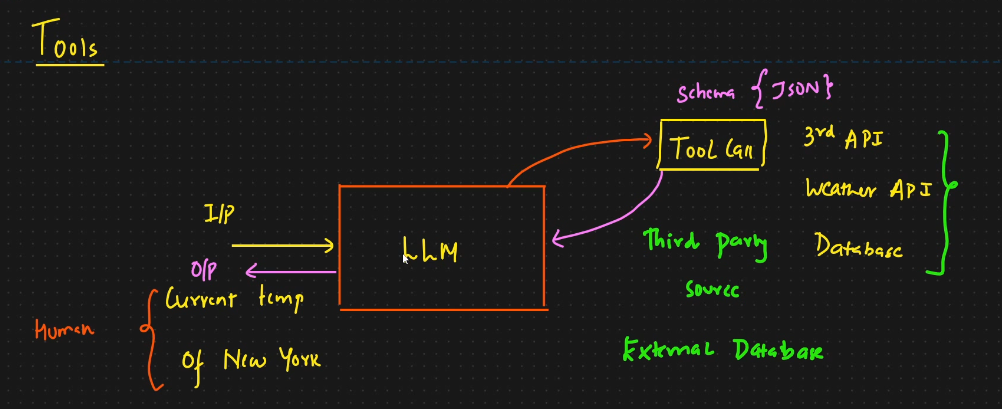

#### How does the LLM decide if call the tool?

The tool is bound to the LLM. It is very smart. It understand from the input if it
need to call the tool. The doc string in the tool to help inform the LLM how and
when to use the tool

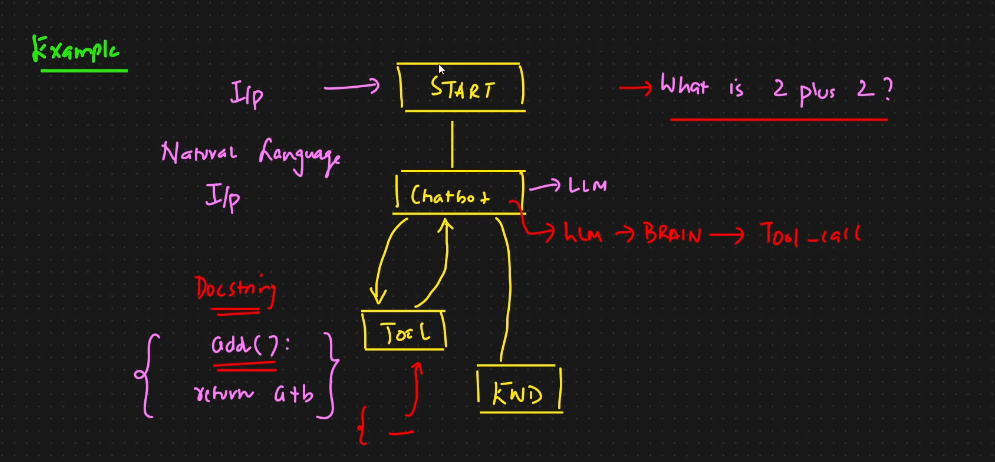



In [5]:
# Here we create the tool
def add(a:int,b:int)-> int:
    """ Add a and b
    Args:
        a (int): first int
        b (int): second int

    Returns:
        int
    """
    return a+b

In [6]:
# Here is the LLM that we are going to use
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7e5e542aace0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7e5e542e4ee0>, model_name='qwen/qwen3-32b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
### Binding tool with llm
llm_with_tools=llm.bind_tools([add])

### Here we invoke with an addition prop
tool_call=llm_with_tools.invoke([HumanMessage(content=f"What is 2 plus 2",name="Krish")])

In [8]:
# Here we look at the tool calls
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': 'amexr4k7e',
  'type': 'tool_call'}]

### Using messages as state

In [9]:
# Here we create a state
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage # AnyMessage can be any of the message types

class State(TypedDict):
    message:list[AnyMessage]

#### Reducers
Now, we have a minor problem!

As we discussed, each node will return a new value for our state key messages.

But, this new value will override the prior messages value.

As our graph runs, we want to append messages to our messages state key.

We can use reducer functions to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should override it as we saw before.

But, to append messages, we can use the pre-built add_messages reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our messages key with the add_messages reducer function as metadata.

In [10]:
# Here we use add_messages reducer to capture all of the messages
from langgraph.graph.message import add_messages
from typing import Annotated

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

### Reducers with add_messages

In [11]:
initial_messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
initial_messages.append(HumanMessage(content=f"I want to learn coding",name="Krish"))
initial_messages

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Krish')]

In [12]:
ai_message=AIMessage(content=f"Which programming language you want to learn",name="LLMModel")
ai_message

AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel')

In [13]:
### Reducers add_messages is to append instead of override
add_messages(initial_messages,ai_message)

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel', id='f3557e92-7b19-4665-8436-6b2e405744ff'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Krish', id='c9be991c-ccc1-4962-81a3-efbcc87a8ce5'),
 AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel', id='725f9b4b-2807-4682-8a5b-49f686c22b93')]

In [14]:
## chatbot node functionality
def llm_tool(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

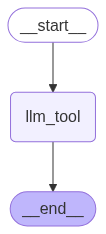

In [15]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
builder=StateGraph(State)

builder.add_node("llm_tool",llm_tool)

builder.add_edge(START,"llm_tool")
builder.add_edge("llm_tool",END)

graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
## Invocation: Here it recognizes that a tool is needed but we don't use it
messages=graph.invoke({"messages":"What is 2 plus 2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (ppqrwg5nb)
 Call ID: ppqrwg5nb
  Args:
    a: 2
    b: 2


In [17]:
tools=[add]

In [22]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition 

builder=StateGraph(State)

## Add nodes
builder.add_node("llm_tool",llm_tool)
builder.add_node("tools",ToolNode(tools))

## Add Edge
builder.add_edge(START,"llm_tool")
builder.add_conditional_edges(
    "llm_tool",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

# Compile the graph
graph = builder.compile()



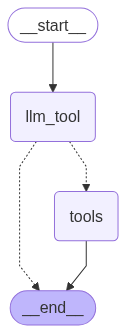

In [23]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
## Invocation: Here we get the output expected
messages=graph.invoke({"messages":"What is 2 plus 2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (xqqgeea35)
 Call ID: xqqgeea35
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4


In [26]:
messages=graph.invoke({"messages":"What is machine learning"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is machine learning
================================== Ai Message ==================================

Machine learning is a subset of artificial intelligence (AI) that focuses on building systems that can learn patterns and make decisions from data without being explicitly programmed. It involves algorithms that improve their performance on a task through experience (i.e., by analyzing large amounts of data). Key concepts include:

1. **Supervised Learning**: Using labeled data to train models (e.g., predicting house prices based on features like size and location).
2. **Unsupervised Learning**: Finding hidden patterns in unlabeled data (e.g., clustering customers by purchasing behavior).
3. **Reinforcement Learning**: Learning optimal actions through trial and error with rewards/penalties (e.g., training a robot to walk).

Applications include image recognition, natural language processing, recommen